# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from glob import glob
from skimage import io
import collections
from imageio import imread
import re
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images/'

all_imgs = glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
a = pd.read_table('Flickr8K/captions.txt',sep=',')

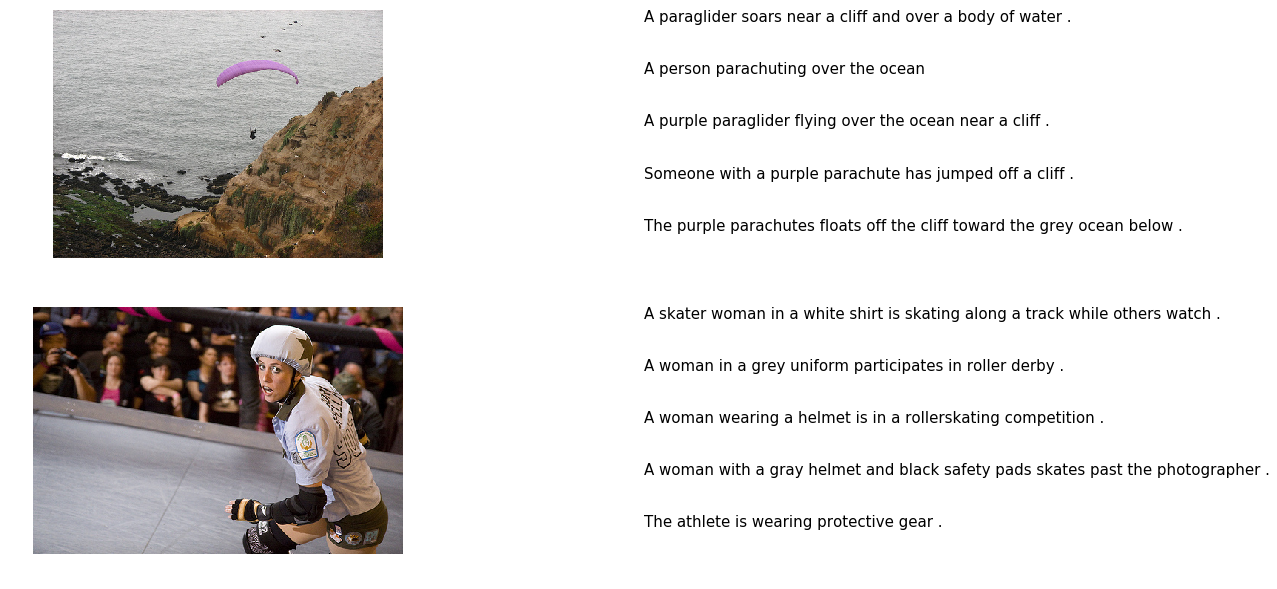

In [4]:
#Visualise both the images & text present in the dataset
b=[]
for i in range(2):
    b.append(np.random.randint(0,8091))
plt.figure(figsize=[24,10])
plt.subplot(2,2,1)
plt.imshow(imread(all_imgs[b[0]]))
plt.axis('off')
plt.subplot(2,2,2)
s=""
for i in a[a.image==all_imgs[b[0]].split('/')[-1]].caption:
    s = s+i+'\n\n\n'
plt.text(0,-.1,s,size=15)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(imread(all_imgs[b[1]]))
plt.axis('off')
plt.subplot(2,2,4)
s=""
for i in a[a.image==all_imgs[b[1]].split('/')[-1]].caption:
    s = s+i+'\n\n\n'
plt.text(0,-.1,s,size=15)
plt.axis('off')
plt.show()

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    text = pd.read_table(filename,sep=',')
    
    return text
text_file = 'Flickr8K/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

                         image  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
295  1077546505_a4f6c4daa9.jpg   
296  1077546505_a4f6c4daa9.jpg   
297  1077546505_a4f6c4daa9.jpg   
298  1077546505_a4f6c4daa9.jpg   
299  1077546505_a4f6c4daa9.jpg   

                                               caption  
0    A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building .  
2     A little girl climbing into a wooden playhouse .  
3    A little girl climbing the stairs to her playh...  
4    A little girl in a pink dress going into a woo...  
..                                                 ...  
295  A boy in blue shorts slides down a slide into ...  
296  A boy in blue swimming trunks slides down a ye...  
297  A boy rides down a slide into a small backyard...  
298  A boy sliding do

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [78]:
all_img_id= doc.image#store all the image id here
all_img_vector= doc.image.apply(lambda x: images+x)#store all the image path here
annotations= doc.caption#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID                                       Path  \
0      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

In [7]:
char = '\s|(?<!\d)[,.](?!\d)#&-'

In [8]:
vocab = {}
for i in df.Captions:
    for j in re.split(char,i):
        if j not in char:
            if j.lower() in vocab:
                vocab[j.lower()]+=1
            else:
                vocab[j.lower()]=1

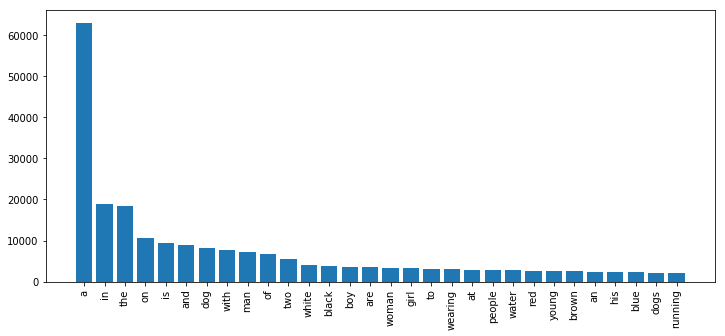

In [9]:
#Visualise the top 30 occuring words in the captions

#write your code here
a = [list(vocab.keys())[i]  for i in  np.argsort(list(vocab.values()))[-1:-31:-1]]
b = [list(vocab.values())[i]  for i in  np.argsort(list(vocab.values()))[-1:-31:-1]]
plt.figure(figsize=[12,5])
plt.bar(x=a,height=b)
plt.xticks(ticks=range(30),labels=a,rotation=90)
plt.show()

In [10]:
#Create a list which contains all the captions

annotations=list(df.Captions.apply(lambda x: '<start> '+x+' <end>').values)#write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=list(df.Path.values)#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# create the tokenizer

#your code here
df.Captions = pd.Series(annotations).apply(lambda x: re.split(char,x.lower()))

In [12]:
# Create word-to-index and index-to-word mappings.

#your code here
topT = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=topT+1,oov_token="UNK",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector=[] #your code here
max_len = max(df.Captions.apply(lambda x: len(x)))
for i in tqdm(range(len(df.ID.unique()))):
    #max_len = max(df[df.ID==df.ID.unique()[i]].Captions.apply(lambda x: len(x)))
    for j in df[df.ID==df.ID.unique()[i]].Captions:
        vec = [tokenizer.word_index[a]  if a in list(tokenizer.word_index.keys())[:5000] else tokenizer.word_index['UNK'] for a in j]
        if len(j)<max_len:
            pad = [0]*(max_len-len(j))
            vec.extend(pad)
        cap_vector.append(vec)
            
cap_vector = np.array(cap_vector)
print("The shape of Caption vector is :" + str(cap_vector.shape))

100%|██████████| 8091/8091 [01:23<00:00, 97.00it/s] 


The shape of Caption vector is :(40455, 40)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [17]:
#write your code here
IMAGE_SHAPE= (299, 299)
def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [18]:
#write your code here
#reference - https://github.com/arunadurai/Eye-For-Blind/blob/main/Eye_For_Blind.ipynb
# mapping each image full path including name to the function to preprocess the image

# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# Mappng preprocess_images_function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [19]:
img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer

In [21]:
#reference - https://github.com/arunadurai/Eye-For-Blind/blob/main/Eye_For_Blind.ipynb
# write your code to extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape) 
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

127it [08:26,  3.30s/it]


In [22]:
#we need to give both images and caption to model as input
def model_input(image,captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,captions

In [26]:
#reference - https://github.com/arunadurai/Eye-For-Blind/blob/main/Eye_For_Blind.ipynb
BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64

def data_generator(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [27]:
train_dataset=data_generator(img_train_data,caption_train_data) 
test_dataset=data_generator(img_test_data,caption_test_data)

In [28]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 40)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [42]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test_data) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=40
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [39]:
#new
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features
    
    def model(self):
        x=tf.keras.Input(shape=(64,2048),batch_size=34)
        return Model(inputs=[x],outputs=self.call(x))

In [40]:
encoder=Encoder(embedding_dim)

In [41]:
encoder.model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(34, 64, 2048)]          0         
_________________________________________________________________
dense_3 (Dense)              (34, 64, 256)             524544    
_________________________________________________________________
tf_op_layer_LeakyRelu (Tenso [(34, 64, 256)]           0         
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


### Attention model

In [43]:
#new
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  tf.matmul(attention_weights, features,transpose_a=True) #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights
    
    def model(self):
        features=tf.keras.Input(shape=(64,256),batch_size=10)
        hidden=tf.keras.Input(shape=(12),batch_size=10)
        return Model(inputs=[features,hidden],outputs=self.call(features,hidden))

In [44]:
attn=Attention_model(275)

In [45]:
attn.model().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(10, 12)]           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(10, 64, 256)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(10, 1, 12)]        0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (10, 64, 275)        70675       input_6[0][0]                    
____________________________________________________________________________________________

### Decoder

In [46]:
#new
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def model(self):
        x=tf.keras.Input(shape=(1),batch_size=1)
        features=tf.keras.Input(shape=(64,256),batch_size=1)
        hidden=tf.keras.Input(shape=(512),batch_size=1)
        return Model(inputs=[x,features,hidden],outputs=self.call(x,features,hidden))

In [47]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [48]:
decoder.model().summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(1, 64, 256)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(1, 512)]           0                                            
__________________________________________________________________________________________________
attention_model_1 (Attention_mo ((1, 256), (1, 64, 1 394753      input_9[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(1, 1)]             0                                            
____________________________________________________________________________________________

In [49]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [50]:
optimizer = tf.keras.optimizers.Adam()#'Adam'#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)#define your loss object

In [51]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [52]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,optimizer=optimizer
                          )
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [53]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [54]:
tf.config.experimental_run_functions_eagerly(True)

In [55]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

In [56]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    xx=[]
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
            # passing encoder_output to the decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
          #xx.append(tf.argmax(predictions,axis=1))

            loss += loss_function(target[:, t], predictions) 

            predicted_id =  tf.argmax(predictions[0]).numpy()
            #print(predicted_id)
            dec_input = tf.expand_dims([predicted_id]* target.shape[0], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

        
    return loss, avg_loss

In [57]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [58]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15
encoder=Encoder(embedding_dim)
decoder=Decoder(embedding_dim, units, vocab_size)

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [20:39<4:49:07, 1239.13s/it]

For epoch: 1, the train loss is 1.248, & test loss is 2.071
Time taken for 1 epoch 1238.9663405418396 sec

Test loss has been reduced from 100.000 to 2.071


 13%|█▎        | 2/15 [41:21<4:28:40, 1240.08s/it]

For epoch: 2, the train loss is 0.971, & test loss is 2.029
Time taken for 1 epoch 1242.1197736263275 sec

Test loss has been reduced from 2.071 to 2.029


 20%|██        | 3/15 [1:01:58<4:07:51, 1239.29s/it]

For epoch: 3, the train loss is 0.886, & test loss is 2.057
Time taken for 1 epoch 1237.4444682598114 sec



 27%|██▋       | 4/15 [1:22:22<3:46:19, 1234.47s/it]

For epoch: 4, the train loss is 0.825, & test loss is 2.073
Time taken for 1 epoch 1223.2373597621918 sec



 33%|███▎      | 5/15 [1:42:47<3:25:16, 1231.69s/it]

For epoch: 5, the train loss is 0.776, & test loss is 2.101
Time taken for 1 epoch 1225.194705247879 sec



 40%|████      | 6/15 [2:03:08<3:04:18, 1228.67s/it]

For epoch: 6, the train loss is 0.731, & test loss is 2.111
Time taken for 1 epoch 1221.63986992836 sec



 47%|████▋     | 7/15 [2:23:48<2:44:14, 1231.84s/it]

For epoch: 7, the train loss is 0.688, & test loss is 2.200
Time taken for 1 epoch 1239.2304046154022 sec



 53%|█████▎    | 8/15 [2:44:19<2:23:41, 1231.64s/it]

For epoch: 8, the train loss is 0.650, & test loss is 2.254
Time taken for 1 epoch 1231.153270483017 sec



 60%|██████    | 9/15 [3:05:09<2:03:43, 1237.31s/it]

For epoch: 9, the train loss is 0.613, & test loss is 2.318
Time taken for 1 epoch 1250.550298690796 sec



 67%|██████▋   | 10/15 [3:25:33<1:42:45, 1233.11s/it]

For epoch: 10, the train loss is 0.579, & test loss is 2.411
Time taken for 1 epoch 1223.2993874549866 sec



 73%|███████▎  | 11/15 [3:45:54<1:21:58, 1229.64s/it]

For epoch: 11, the train loss is 0.546, & test loss is 2.472
Time taken for 1 epoch 1221.5469813346863 sec



 80%|████████  | 12/15 [4:06:28<1:01:32, 1230.93s/it]

For epoch: 12, the train loss is 0.517, & test loss is 2.501
Time taken for 1 epoch 1233.9482629299164 sec



 87%|████████▋ | 13/15 [4:27:14<41:10, 1235.32s/it]  

For epoch: 13, the train loss is 0.489, & test loss is 2.566
Time taken for 1 epoch 1245.552895784378 sec



 93%|█████████▎| 14/15 [4:47:53<20:36, 1236.53s/it]

For epoch: 14, the train loss is 0.463, & test loss is 2.658
Time taken for 1 epoch 1239.3616833686829 sec



100%|██████████| 15/15 [5:08:29<00:00, 1236.25s/it]

For epoch: 15, the train loss is 0.441, & test loss is 2.764
Time taken for 1 epoch 1235.5817334651947 sec



/mnt/disks/user/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


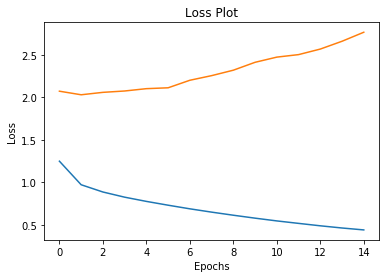

In [59]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [60]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [61]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [62]:
from nltk.translate.bleu_score import sentence_bleu

In [63]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

# Testing

In [65]:
img_test_data=img_test_data.reset_index(drop=True)
img_train_data=img_train_data.reset_index(drop=True)
all_img_id= doc.image#store all the image id here
all_img_vector= doc.image.apply(lambda x: images+x)#store all the image path here
annotations= doc.caption#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 1.1069497500760966e-152
Real Caption: a dirty jeep is stuck in the mud UNK
Prediction Caption: a muddy jeep driving through the woods UNK


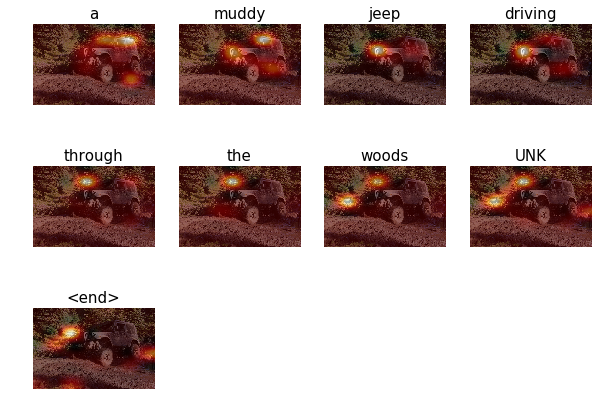

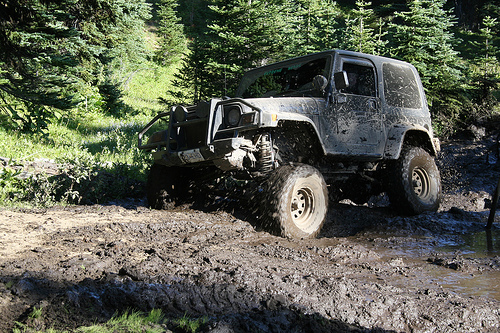

In [76]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_test_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [79]:
df[df.Path== test_image].Captions

5165                   A dirty jeep is stuck in the mud .
5166    A Jeep goes off-roading in the woods with mudd...
5167            A muddy jeep driving through the forest .
5168                         A muddy truck in the woods .
5169    The vehicle is driving through mud surrounded ...
Name: Captions, dtype: object

BELU score: 1.1896457329133972e-229
Real Caption: young boy wearing red coat eats chocolate bar
Prediction Caption: girl in red jacket is holding candy bar with his feet


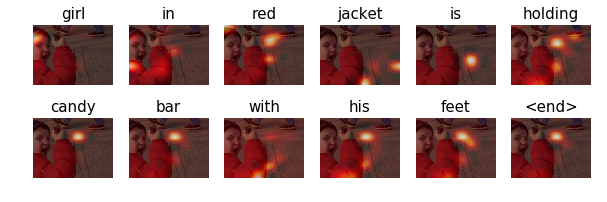

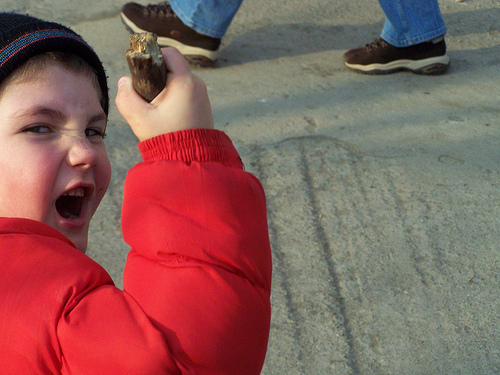

In [117]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_test_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [118]:
df[df.Path== test_image].Captions

7385    A boy in a red jacket holding a stick and yelling                          
7386    A kid turns around with an object in hand while someone passes behind him  
7387    A young boy holds up a candy bar while yelling                             
7388    A young boy wearing a red coat eats a chocolate bar                        
7389    A young boy wearing a red winter coat is eating and holding up a candy bar 
Name: Captions, dtype: object

BELU score: 1.0518351895246306e-229
Real Caption: man wearing glasses and green bow tie
Prediction Caption: an old man with bowtie looks at the camera


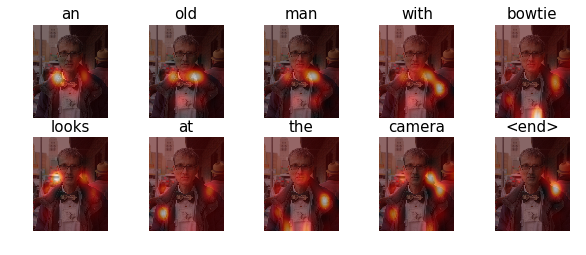

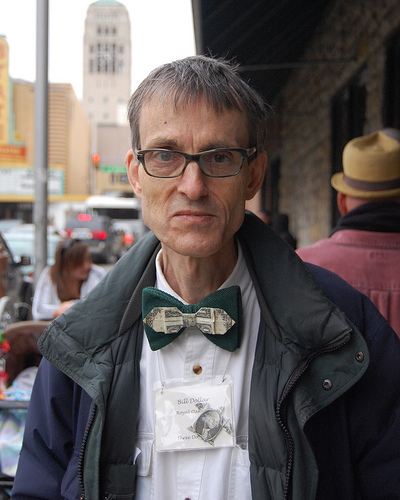

In [120]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_test_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [123]:
df[df.Path== test_image].Captions

27165    A man wearing a bow tie and glasses poses for a photo                                    
27166    A man wearing glasses and a green bow tie                                                
27167    A man with a bow-tie looks at the camera with no expression                              
27168    A man with a bow-tie made out of a dollar and wearing glasses is looking into the camera 
27169    An old man wearing a green bow-tie and glasses looking toward the camera                 
Name: Captions, dtype: object

BELU score: 7.865406450922293e-230
Real Caption: two brown dogs play with one another in the field
Prediction Caption: brown dog hops in grassy field


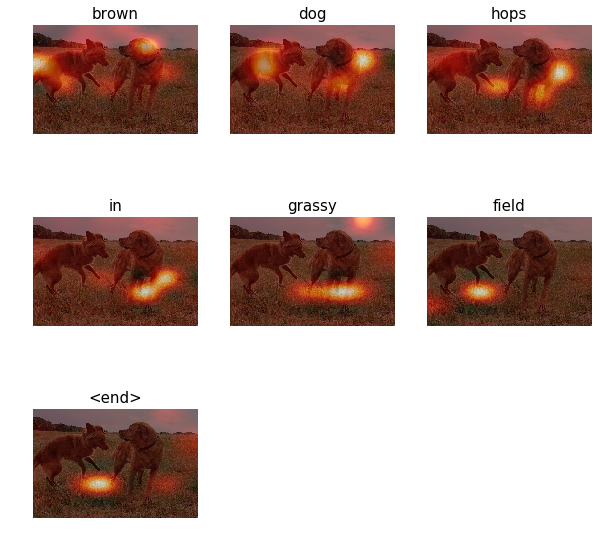

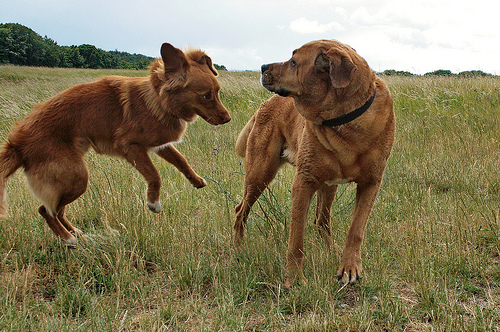

In [127]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_test_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [128]:
df[df.Path== test_image].Captions

11835    A dog hops in a field while another dog stands next to it 
11836    One dog is jumping up at another dog in a grassy field    
11837    "The two tan colored dogs are in a field                  
11838    Two brown dogs in a field                                 
11839    Two brown dogs play with one another in the field         
Name: Captions, dtype: object

BELU score: 6.458654791343582e-153
Real Caption: the man is riding bike down dirt hill
Prediction Caption: person riding bike through the dirt


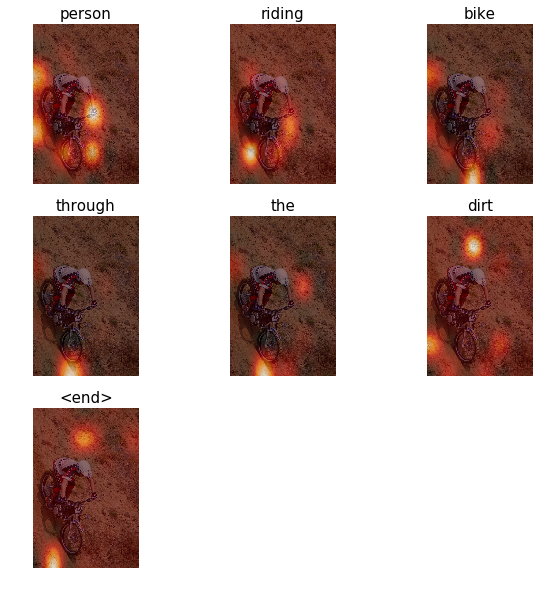

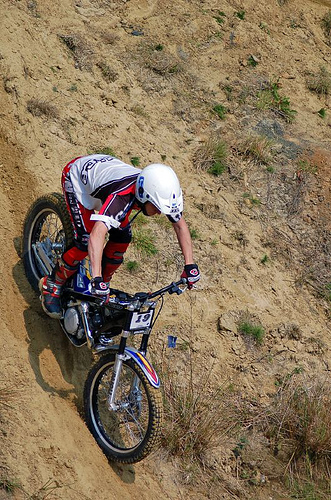

In [133]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_test_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [134]:
df[df.Path== test_image].Captions

37155    A man riding a dirt bike in down a hill in competition 
37156    "A motocross rider wearing red                         
37157    "A motorcycle racer going down a steep                 
37158    A person rides a motorbike down a dirt hill            
37159    The man is riding a bike down a dirt hill              
Name: Captions, dtype: object

## On Train data

BELU score: 1.693650650206808e-76
Real Caption: two fencers in white suits and black masks compete in gymnasium setting
Prediction Caption: two fencers in fencing class


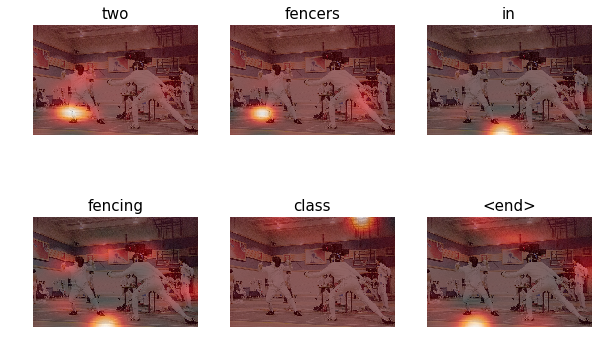

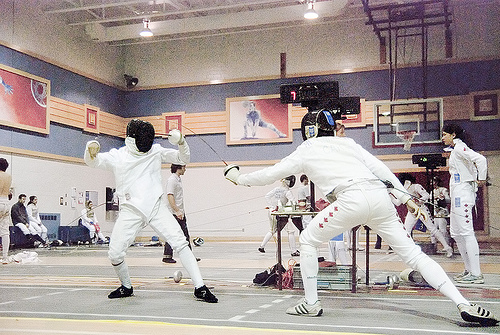

In [138]:
rid = np.random.randint(0, len(img_train_data))
test_image = img_train_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_train_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [139]:
df[df.Path== test_image].Captions

23925    A few players show off their jousting skills in a gym                     
23926    The people in the masks are fencing                                       
23927    Two fencers in full gear duel in a gym                                    
23928    Two fencers in gear fighting in a fencing class                           
23929    Two fencers in white suits and black masks compete in a gymnasium setting 
Name: Captions, dtype: object

BELU score: 3.645525559050358e-153
Real Caption: two young kids walking towards the sidewalk out of the snow
Prediction Caption: two children are in the snow


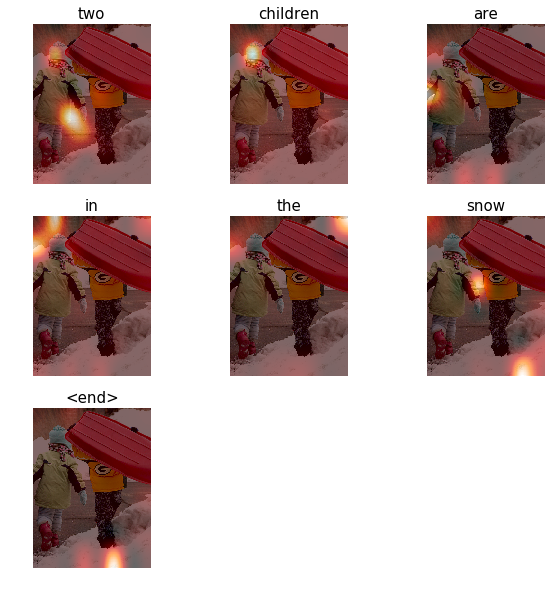

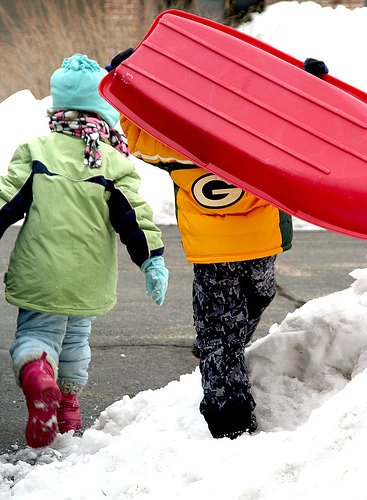

In [142]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_train_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_train_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [143]:
df[df.Path== test_image].Captions

35890    A little girl in a green coat and a boy holding a red sled walk in the snow                 
35891    Child wearing a Green Bay coat carrying a red sled behind a child in a green and black coat 
35892    Two children and walking through the snow carrying a sled                                   
35893    Two small children in snow clothes are walking through the snow while one carries a red sled
35894    two young kids walking towards the sidewalk out of the snow                                 
Name: Captions, dtype: object

BELU score: 6.848990852664275e-153
Real Caption: woman pulling wagon with girl in it across frozen lake
Prediction Caption: woman pulls little girl in the cart across the ice


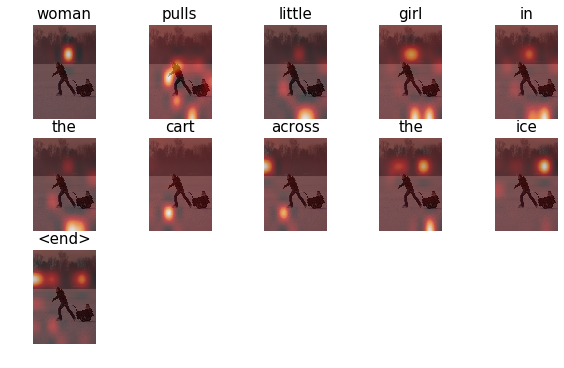

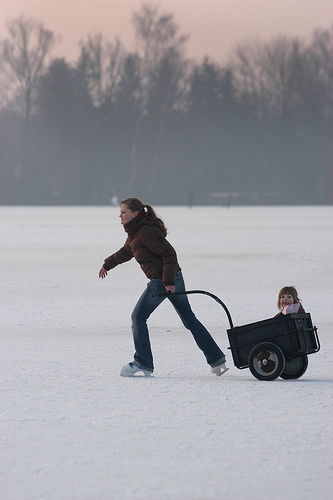

In [157]:
rid = np.random.randint(0, len(img_train_data))
test_image = img_train_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_train_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [158]:
df[df.Path== test_image].Captions

40150    A lady ice skates while pulling a child in a buggy                              
40151    A mother pulls her daughter in a wagon over a snowy plain                       
40152    A woman pulling a wagon with a girl in it across a frozen lake                  
40153    The girl pulls a toddler in a cart while skating on the ice                     
40154    The woman is ice skating and pulling the little girl in the cart across the ice 
Name: Captions, dtype: object

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 7.64905473570869e-76
Real Caption: africans wearing colorful clothing gather behind a fence UNK
Prediction Caption: a tribal group of people are sitting in front of thatched UNK UNK


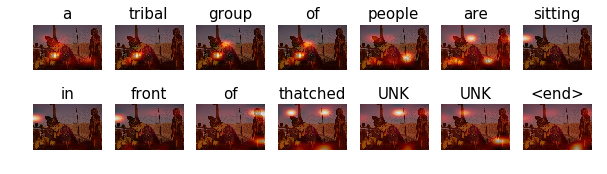

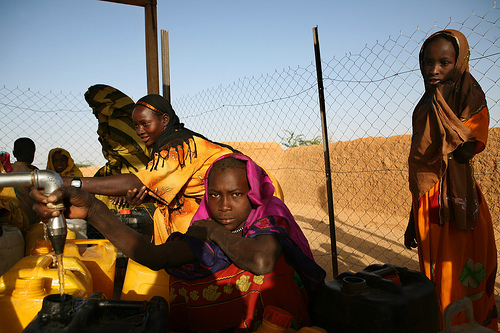

In [93]:
rid = np.random.randint(0, len(img_test_data))
test_image = img_train_data[rid]
#test_image=image
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_train_data[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
#real_caption = " ".join(result)

real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [96]:
df[df.Path== test_image].Captions

24575            Africans gather water at an outdoor tap .
24576    Africans wearing colorful clothing gather behi...
24577    A tribal group filling water jugs in the desert .
24578    People filling a large black container with wa...
24579    Women of African origin are colecting water at...
Name: Captions, dtype: object

# Conclusion:

## First approach:
    
    In First approach I tried to split the data on basis of unique images. But it was not giving good result. As the number of images are less. SO most of the features are not identified.
    So dropped this approach
    
## Second approach
    
    Here we splitted the data in random basis so that all the images are preseny in training data. It is giving good result. The test loss is not decreasing by approach but in testing the results are looking good. 
    
### Note:
        For creating the train and test dataset took reference from - https://github.com/arunadurai/Eye-For-Blind/blob/main/Eye_For_Blind.ipynb